## plotNWT_hillslope_simple
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# supress Runtime warnings that let you know when code isn't too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['DM','MM']
longSite  =  ['dry meadow','moist meadow']#'dry_meadow'
#case  =  ['NEON_NIWO_hh_test']
case  =  ['NEON_NIWO_3col_dm01_newSoil_trans','NEON_NIWO_3col_mm01_newSoil_trans']
rollHour = -12  
years = range(2008,2020)
nmon  = 12

#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
# dirIn = ['/glade/scratch/wwieder/'+case[c]+'/run/' for c in range(len(case))]
dmfiles = [dirIn[0] + case[0] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
mmfiles = [dirIn[1] + case[1] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(dmfiles[0])
print(mmfiles[0])

/glade/scratch/wwieder/archive/NEON_NIWO_3col_dm01_newSoil_trans/lnd/hist/NEON_NIWO_3col_dm01_newSoil_trans.clm2.h1.2008-01-01-00000.nc
/glade/scratch/wwieder/archive/NEON_NIWO_3col_mm01_newSoil_trans/lnd/hist/NEON_NIWO_3col_mm01_newSoil_trans.clm2.h1.2008-01-01-00000.nc


--- 
### Read in dataset 
- get rid of extra dimensions
- remove CLM time shift

In [6]:
%%time
ds_dm = utils.time_set_mid(xr.open_mfdataset(dmfiles, decode_times=True, combine='by_coords'), 'time')
ds_mm = utils.time_set_mid(xr.open_mfdataset(mmfiles, decode_times=True, combine='by_coords'), 'time')
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 29.3 s, sys: 733 ms, total: 30 s
Wall time: 40.3 s


In [7]:
#ds_mm

#### Combine pft and column coordinates
#### Then combine datasets 

In [7]:
ds_dm = ds_dm.rename({'pft':'column'})
ds_mm = ds_mm.rename({'pft':'column'})
ds = ds_dm.where(ds_dm.column==2, ds_mm)
ds.GPP

<xarray.DataArray 'GPP' (time: 210240, column: 3)>
dask.array<where, shape=(210240, 3), dtype=float32, chunksize=(17520, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:15:00
Dimensions without coordinates: column
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [8]:
ds.column

<xarray.DataArray 'column' (column: 3)>
array([0, 1, 2])
Dimensions without coordinates: column

In [8]:
ds = ds.assign_coords({"column": ["mm", "wm", "dm"]})

### Sample surface dataset has 
- all columns have arctic C3 grass
- not sure what `hslp_cold` is about, but it seems to have missing values for the highest elevation columns.  Also, lateral flow is more regular from these columns (see plot below)

In [10]:
print(ds.hslp_aspect.values)
print()
print(ds.hslp_elev.values)
print()
print(ds.pfts1d_itype_veg.values)
print()
print(ds.hslp_cold.values)
print()
print(ds.cols1d_nbedrock.values)

[[1.57079633 0.         4.71238898]
 [1.57079633 0.         4.71238898]
 [1.57079633 0.         4.71238898]
 ...
 [1.57079633 0.         4.71238898]
 [1.57079633 0.         4.71238898]
 [1.57079633 0.         4.71238898]]

[[3.75 0.75 3.75]
 [3.75 0.75 3.75]
 [3.75 0.75 3.75]
 ...
 [3.75 0.75 3.75]
 [3.75 0.75 3.75]
 [3.75 0.75 3.75]]

[[12. 12. 12.]
 [12. 12. 12.]
 [12. 12. 12.]
 ...
 [12. 12. 12.]
 [12. 12. 12.]
 [12. 12. 12.]]

[[    2 -9999     2]
 [    2 -9999     2]
 [    2 -9999     2]
 ...
 [    2 -9999     2]
 [    2 -9999     2]
 [    2 -9999     2]]

[[10.  9.  9.]
 [10.  9.  9.]
 [10.  9.  9.]
 ...
 [10.  9.  9.]
 [10.  9.  9.]
 [10.  9.  9.]]


In [12]:
#ds.cols1d_nbedrock

<xarray.DataArray 'cols1d_nbedrock' (time: 210240, column: 3)>
dask.array<where, shape=(210240, 3), dtype=float64, chunksize=(17520, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:15:00
  * column   (column) <U2 'mm' 'wm' 'dm'
Attributes:
    long_name:  column bedrock depth index

In [15]:
print(ds.cols1d_wtgcell.values)
ds.GPP

[[0.42857143 0.14285714 0.42857143]
 [0.42857143 0.14285714 0.42857143]
 [0.42857143 0.14285714 0.42857143]
 ...
 [0.42857143 0.14285714 0.42857143]
 [0.42857143 0.14285714 0.42857143]
 [0.42857143 0.14285714 0.42857143]]


<xarray.DataArray 'GPP' (time: 210240, column: 3)>
dask.array<where, shape=(210240, 3), dtype=float32, chunksize=(17520, 3), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:15:00
  * column   (column) <U2 'mm' 'wm' 'dm'
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

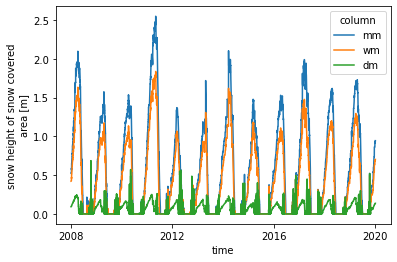

In [11]:
ds.SNOW_DEPTH.plot(hue='column') ;

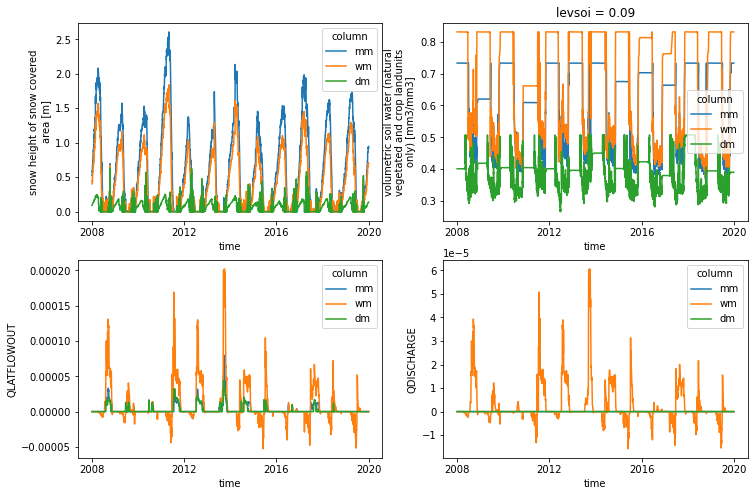

In [12]:
plt.figure(figsize=[12,8])
plt.subplot(221)
ds.SNOW_DEPTH.plot(hue='column') 
plt.subplot(222)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');

plt.subplot(223)
ds.QLATFLOWOUT.resample(time='D').mean('time').plot(hue='column') ;
plt.subplot(224)
ds.QDISCHARGE.resample(time='D').mean('time').plot(hue='column') ;


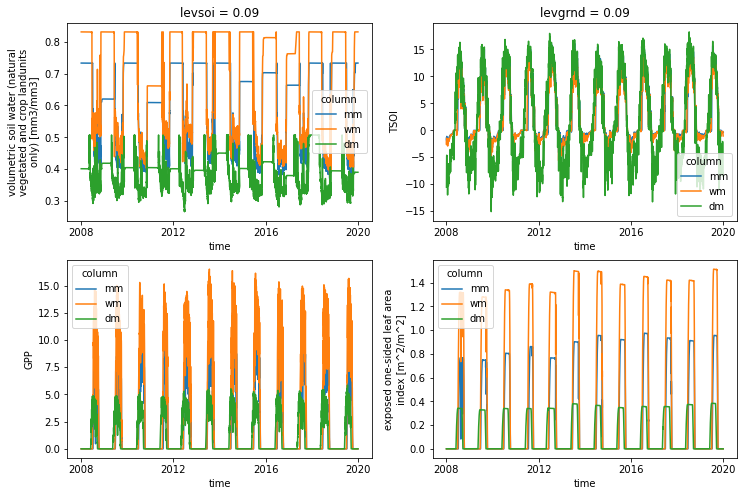

In [16]:
plt.figure(figsize=[12,8])

plt.subplot(221)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');
plt.subplot(222)
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');
plt.subplot(223)
(ds.GPP.resample(time='D').mean('time')*24*3600).plot(hue='column') ; #gC/m2/d
plt.subplot(224)
ds.ELAI.plot(hue='column');

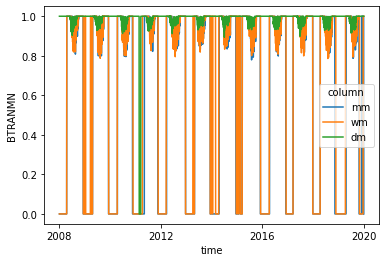

In [17]:
ds.BTRANMN.resample(time='D').mean('time').plot(hue='column') ; #.plot(hue='pft');
#ds.QDISCHARGE.isel(column=0).groupby('time.dayofyear').sum().values

gC/m^2/s


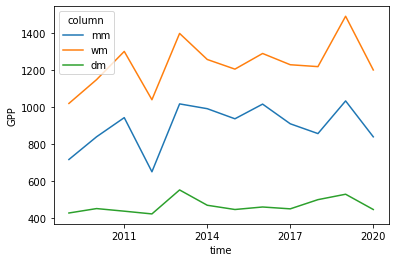

In [9]:
print(ds.GPP.attrs['units'])
(ds.GPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column') ;

In [27]:
# Reverse axes here
ds['levsoi'] = ds.levsoi * -1

In [28]:
ds.levsoi 

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([-0.01, -0.04, -0.09, -0.16, -0.26, -0.4 , -0.58, -0.8 , -1.06, -1.36,
       -1.7 , -2.08, -2.5 , -2.99, -3.58, -4.27, -5.06, -5.95, -6.94, -8.03],
      dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 -0.01 -0.04 -0.09 -0.16 ... -5.95 -6.94 -8.03

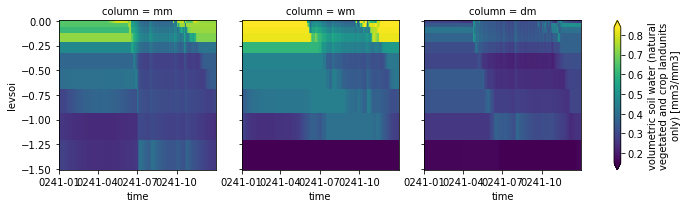

In [29]:
g_simple = ds.H2OSOI.isel(levsoi=slice(0,10)).plot(x="time", y="levsoi", col="column", col_wrap=3, robust=True)

In [30]:
ds['levgrnd'] = ds.levgrnd * -1

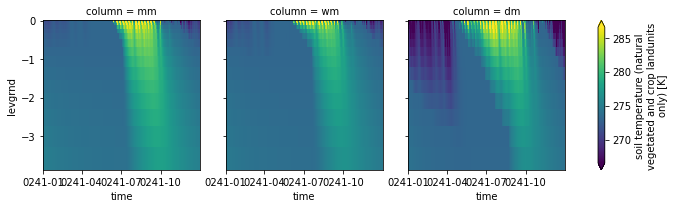

In [31]:
g_simple = ds.isel(levgrnd=slice(0,15)).TSOI.plot(x="time", y="levgrnd", col="column", col_wrap=3, robust=True)

In [28]:
# ds

<xarray.Dataset>
Dimensions:             (column: 3, gridcell: 1, hist_interval: 2, landunit: 1, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, time: 210240)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:1...
  * column              (column) <U2 'mm' 'wm' 'dm'
Dimensions without coordinates: gridcell, hist_interval, landunit, lndgrid
Data variables:
    hslp_distance       (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_width          (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_area           (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_elev           (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_slope          (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_aspect         (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_index          (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_cold           (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_colu           (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mcdate              (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mcsec               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mdcur               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mscur               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    nstep               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    time_bounds         (time, hist_interval, column) object dask.array<chunksize=(17520, 2, 3), meta=np.ndarray>
    date_written        (time, column) |S16 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    time_written        (time, column) |S16 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    lon                 (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    lat                 (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    area                (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    landfrac            (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    landmask            (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    pftmask             (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    nbedrock            (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_lon          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_lat          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_ixy          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_jxy          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_lon          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_lat          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_ixy          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_jxy          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=

In [12]:
ds['NPP'] = ds.GPP - ds.AR

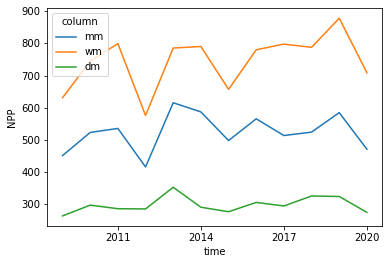

In [13]:
(ds.NPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column');

## Reading in observations to compare with simulations

In [15]:
nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsNPP.data = pd.to_datetime(dsNPP.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

In [17]:
print(dsSOI)

             plot       date  Hour  soiltemp_upper_avg  soiltemp_lower_avg  \
0               6 2017-10-19  14.0            0.957333            0.643333   
1               6 2017-10-19  14.5            0.957000            0.642000   
2               6 2017-10-19  15.0            0.957000            0.640667   
3               6 2017-10-19  15.5            0.956333            0.639333   
4               6 2017-10-19  16.0            0.956000            0.638333   
...           ...        ...   ...                 ...                 ...   
183374  Tvan_West 2020-08-10  22.5           16.353610            7.760121   
183375  Tvan_West 2020-08-10  23.0           15.916520            7.789364   
183376  Tvan_West 2020-08-10  23.5           15.496630            7.665685   
183377  Tvan_West 2020-08-11   0.0           15.086610            7.491287   
183378  Tvan_West 2020-08-11   0.5           14.720390            7.313446   

        soilmoisture_upper_avg  soilmoisture_lower_avg veg_com 

In [16]:
# Aggregate data by date & vegetation community 
# This is already done for snowdepth
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

In [13]:
## Converting Saddle network data to xarray

In [17]:
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()

# reindex by veg community for plotting consistency
Veg = ["DM", "MM","WM"]
fullVeg = ["dry_meadow", "moist_meadow","wet_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

veg  = ["dm","mm","wm"]
#ds = ds.reindex({'column': fullVeg})

In [15]:
## Quick plots

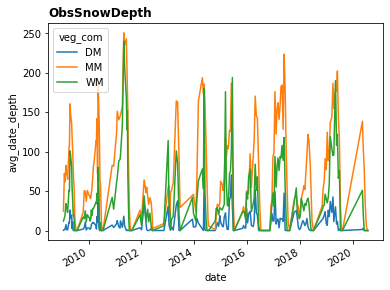

In [18]:
# Snow depth
dsSNO.where(dsSNO['date.year']>2008).avg_date_depth.plot(hue='veg_com');
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

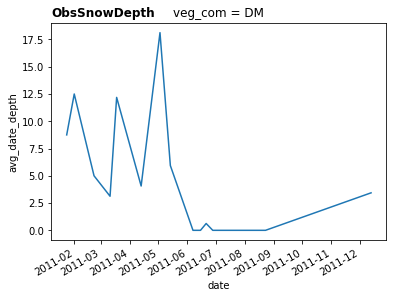

In [19]:
dsSNO.sel(veg_com='DM').where(dsSNO['date.year']==2011).avg_date_depth.plot();
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

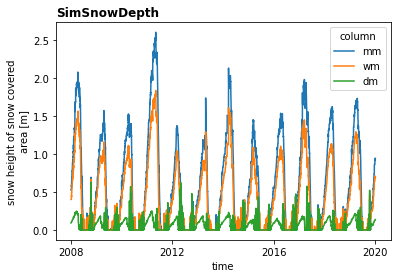

In [14]:
ds.SNOW_DEPTH.plot(hue='column') ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

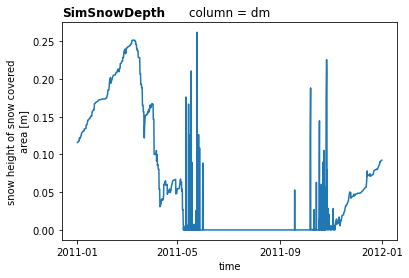

In [20]:
ds.sel(column='dm').where(ds['time.year']==2011).SNOW_DEPTH.plot() ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

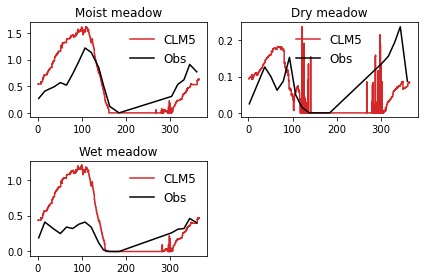

In [63]:
plotYear =  2018
com_sim = 'mm'
com_obs = 'MM'

x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y = ds.sel(column='mm').where(ds['time.year']==plotYear).SNOW_DEPTH

x2 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y2 = dsSNO.sel(veg_com='MM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

x3 = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y3 = ds.sel(column='dm').where(ds['time.year']==plotYear).SNOW_DEPTH

x4 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y4 = dsSNO.sel(veg_com='DM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

x5 = ds['time.dayofyear'].where(ds['time.year']==plotYear)
y5 = ds.sel(column='wm').where(ds['time.year']==plotYear).SNOW_DEPTH

x6 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)
y6 = dsSNO.sel(veg_com='WM').where(dsSNO['date.year']==plotYear).avg_date_depth/100

fig, axs = plt.subplots(2, 2)

axs[0,0].plot(x, y, color='tab:red')
axs[0,0].plot(x2, y2, color='black')
axs[0,0].set_title("Moist meadow")
axs[0,1].plot(x3, y3, color='tab:red')
axs[0,1].plot(x4, y4, color='black')
axs[0,1].set_title("Dry meadow")
axs[1,0].plot(x5, y5, color='tab:red')
axs[1,0].plot(x6, y6, color='black')
axs[1,0].set_title("Wet meadow")

#ax.plot(x, y, color='tab:red')
#ax.plot(x2, y2, color='black')
axs[0,0].legend(('CLM5','Obs'), frameon=False,fontsize='large')
axs[0,1].legend(('CLM5','Obs'), frameon=False,fontsize='large')
axs[1,0].legend(('CLM5','Obs'), frameon=False,fontsize='large')

axs.flat[-1].set_visible(False)
fig.tight_layout()
plt.show()

AttributeError: 'DataArrayResample' object has no attribute 'calendar'

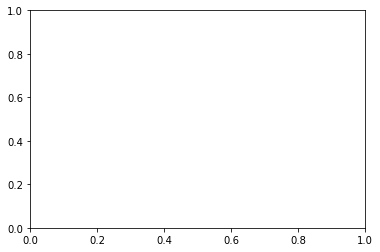

In [43]:
#ds.NPP.resample(time='Y').mean('time').plot(hue='column');
plotYear =  2018
com_sim = 'mm'
com_obs = 'MM'

x = ds['time.dayofyear'].where(ds['time.year']==plotYear).resample(time='Y')
y = ds.sel(column=com_sim).where(ds['time.year']==plotYear).resample(time='Y').mean('time').NPP

x2 = dsNPP['year'].where(dsNPP['year']==plotYear)
y2 = dsNPP.sel(veg_com=com_obs).where(dsNPP['year']==plotYear).NPP
#y2STD = dsSNOstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)

fig, ax = plt.subplots()

ax.plot(x, y, color='tab:red')
ax.plot(x2, y2, color='black')
ax.legend(('CLM5','Obs'), frameon=False,fontsize='large')
plt.show()

In [36]:
dsNPP

<xarray.Dataset>
Dimensions:         (veg_com: 3, year: 16)
Coordinates:
  * veg_com         (veg_com) object 'DM' 'MM' 'WM'
  * year            (year) int64 1992 1993 1994 1995 ... 2016 2017 2018 2019
Data variables:
    grid_pt         (year, veg_com) float64 nan 44.72 51.2 ... 219.7 44.69 51.2
    subsample_none  (year, veg_com) float64 nan 199.8 149.4 nan ... nan nan nan
    subsample_A     (year, veg_com) float64 nan nan nan ... 141.3 216.4 192.0
    subsample_B     (year, veg_com) float64 nan nan nan nan ... nan nan nan
    NPP             (year, veg_com) float64 nan 199.8 149.4 ... 216.4 192.0

In [38]:
dsSNO

<xarray.Dataset>
Dimensions:         (date: 242, veg_com: 3)
Coordinates:
  * veg_com         (veg_com) object 'DM' 'MM' 'WM'
  * date            (date) datetime64[ns] 2007-02-06 2007-03-14 ... 2020-07-21
Data variables:
    DoY             (date, veg_com) float64 37.0 37.0 37.0 ... 203.0 203.0 203.0
    Year            (date, veg_com) float64 2.007e+03 2.007e+03 ... 2.02e+03
    avg_date_depth  (date, veg_com) float64 4.688 36.15 4.0 ... 0.0 0.0 0.0
    sd_date_depth   (date, veg_com) float64 17.46 42.43 5.477 ... 0.0 0.0 0.0

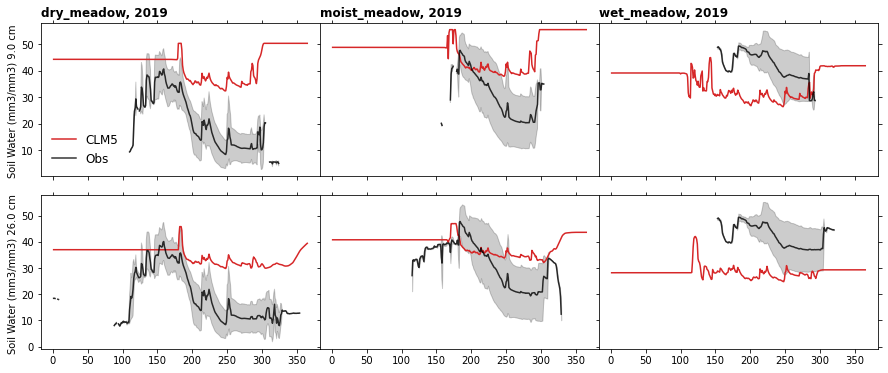

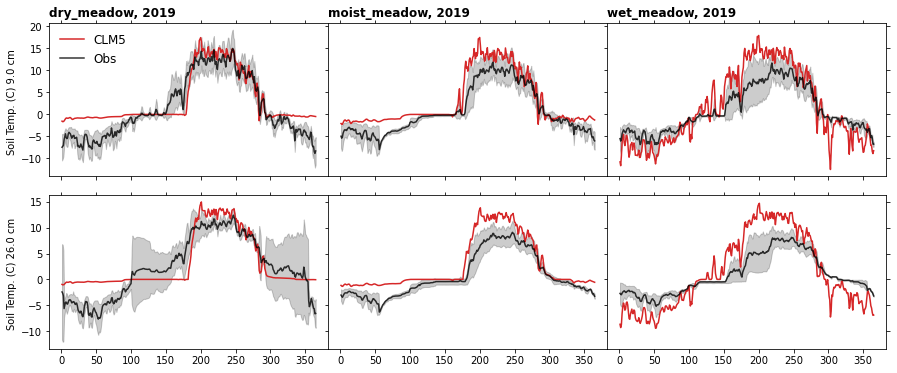

In [99]:
nyear = len(years) 
clmVARS = ['H2OSOI','TSOI']
obsVARSu = ['soilmoisture_upper_avg','soiltemp_upper_avg']
obsVARSl = ['soilmoisture_lower_avg','soiltemp_lower_avg']
plotYear =  2019

for v in range(len(clmVARS)):
    fig, axs = plt.subplots(2, len(Veg), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0.12},
                        figsize=(15,6))    
    for i in range(len(Veg)):
        for j in range(2):
            if i == 0: 
                nlev = 2 #10 cm for fell field
            else: 
                nlev = 1 # 5 cm for sensor network
            if j == 1: nlev = 4

            # Select data to plot    
            x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
            x2 = dsSOI['date.dayofyear'].where(dsSOI['date.year']==plotYear)

            if v == 0:
                y = ds[clmVARS[v]].isel(levsoi=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() * 100
            else:
                y = ds[clmVARS[v]].isel(levgrnd=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() -273.15
            
            if j == 0: 
                y2 = dsSOI[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if j == 1: 
                y2 = dsSOI[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            x = x.groupby(x).mean()
            
            axs[j,i].plot(x, y, '-',color='tab:red')
            axs[j,i].plot(x2, y2, '-', color='k', alpha=0.8)
            axs[j,i].fill_between(x2, y2-ySTD, y2+ySTD, alpha=0.2,color='k')
            axs[j,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
            axs[j,i].xaxis.set_ticks_position('both')     


            # control titles & axis labels
            # label columns of data with variable names
            depth = str(np.round(ds["levgrnd"].isel(levgrnd=nlev).values * 100,0))
            if j == 0:
                axs[j,i].set_title(fullVeg[i]+", "+str(plotYear), 
                                   loc='left', fontsize='large', fontweight='bold')
                if i == 0 :
                    axs[j,i].legend(('CLM5','Obs'), frameon=False,fontsize='large')
            #if j == 1:
                #axs[j,i].set_title(depth + " cm ", loc='left', fontsize='large', fontweight='bold')
            if i == 0:
                if v == 0:
                    axs[j,i].set_ylabel('Soil Water (mm3/mm3) '+depth+ " cm ");
                else:
                    axs[j,i].set_ylabel('Soil Temp. (C) '+depth+ " cm ");

In [54]:
x

<xarray.DataArray 'dayofyear' (time: 210240)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:15:00

In [102]:
ds.column

<xarray.DataArray 'column' (column: 3)>
array(['mm', 'wm', 'dm'], dtype='<U2')
Coordinates:
  * column   (column) <U2 'mm' 'wm' 'dm'

In [57]:
y

<xarray.DataArray 'H2OSOI' (dayofyear: 365)>
dask.array<mul, shape=(365,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    levsoi     float32 0.09
    column     <U2 'dm'
  * dayofyear  (dayofyear) float64 1.0 2.0 3.0 4.0 ... 362.0 363.0 364.0 365.0

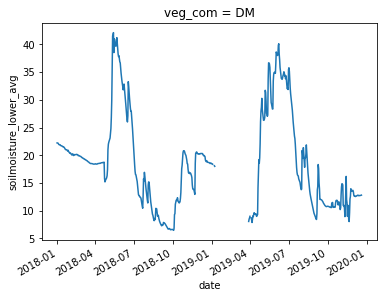

In [31]:
dsSOI.sel(veg_com='DM').where(dsSOI['date.year']>2017).soilmoisture_lower_avg.plot();

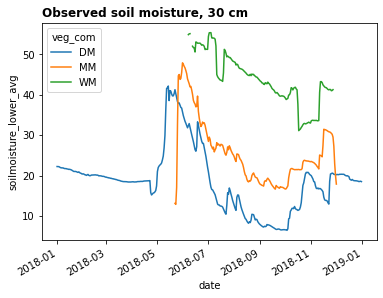

In [39]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_lower_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 30 cm', loc='left', fontsize='large', fontweight='bold');

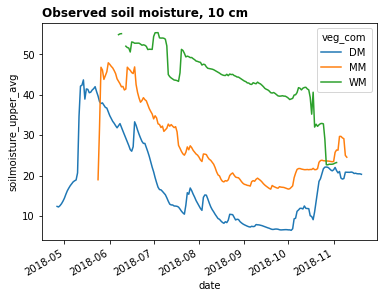

In [40]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_upper_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 10 cm', loc='left', fontsize='large', fontweight='bold');

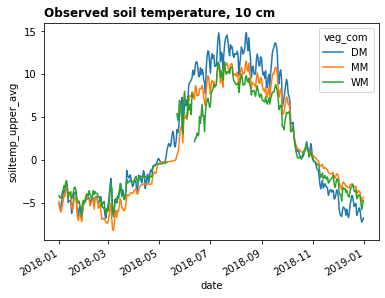

In [43]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_upper_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 10 cm', loc='left', fontsize='large', fontweight='bold');

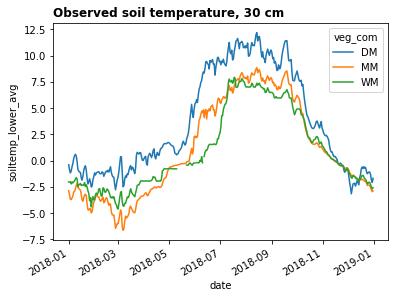

In [44]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_lower_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 30 cm', loc='left', fontsize='large', fontweight='bold');

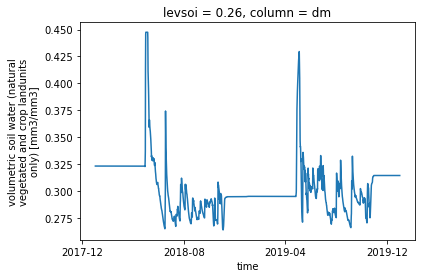

In [34]:
ds.isel(levsoi=4).sel(column='dm').where(ds.H2OSOI['time.year']>2017).H2OSOI.plot(hue='column');

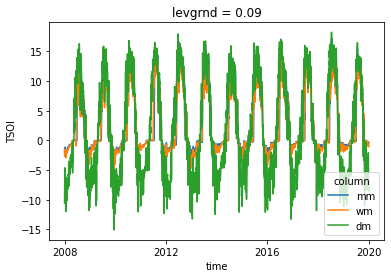

In [33]:
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');

In [33]:
## Read in Tvan flux tower data

In [45]:
# Niwot LTER  simulations
site  = ['ff_newPHS_lowSLA_SAND_cn32_upG1',
         'ff_newPHS_lowSLA_SAND_cn32']
longSite  =  'fell_field'#'dry_meadow'
rollHour = -12  
case  = ['clm50bgc_NWT_'+site[s] for s in range(len(site))]
years = range(2008,2020)
nmon  = 12
OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
OUTdir = OBSdir
#print(OBSfile)


In [46]:
# read in data
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')

In [47]:
# get rid of extra dimensions & coordinates 
dsOBS  = dsOBS.isel(lat=0, lon=0)

In [48]:
# calculate daily means, mask out non-growing season & calculate rolling mean
# super slow when we compute
# no GPP before May 15 & growing season ends Sept 30 (DOY = 135, 273)

temp = dsOBS[['GPP','TBOT']].resample(time='D').mean()   #daily fluxes
temp = temp.where(temp['time.dayofyear']>135,0)  
temp = temp.where(temp['time.dayofyear']<273,0).chunk({'time':100}) 
# set GPP<0 to zero
temp['GPP'] = temp['GPP'].where(temp['GPP']>0,0)
temp['GPP'] = temp['GPP']*3600*24*1e-6*12     # convert flux from umol co2/m2/s to gC/m2/d
temp = temp.rolling(time=10, center=True).mean()#.dropna("time") # rolling mean
#.compute(skipna=True)
print(temp)

<xarray.Dataset>
Dimensions:  (time: 4380)
Coordinates:
  * time     (time) object 2008-01-01 00:00:00 ... 2019-12-31 00:00:00
    lat      float64 40.05
    lon      float64 105.6
Data variables:
    GPP      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    TBOT     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>


In [93]:
# calculate Rnet from absorbed - reflected radiation
ds['Rnet'] = ds.FSA - ds.FIRA	
ds['Rnet'].attrs['units'] = ds.FSA.attrs['units']
ds['Rnet'].attrs['long_name'] = 'net radiation'

In [95]:
# convert obs GPP units from umol/m2/s to g/m2/h
# assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'
# convert clm GPP units from g/m2/s to g/m2/h
ds['GPP'] = ds.GPP * 3600
ds['GPP'].attrs['units'] = 'gC/m2/h'

In [49]:
## Make seasonal plots

In [96]:
dsOBS['season'] = dsOBS['time.season']
ds['season'] = ds['time.season']

Var = ['Rnet','FSH','GPP']
Season = ['DJF','MAM','JJA','SON']

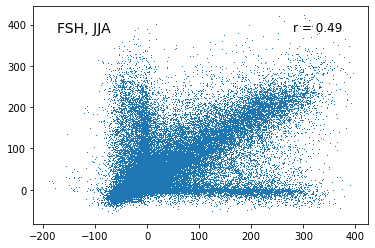

In [85]:

fig, ax = plt.subplots()
x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values,  \
    ds[Var[0]][:,2].where(ds.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

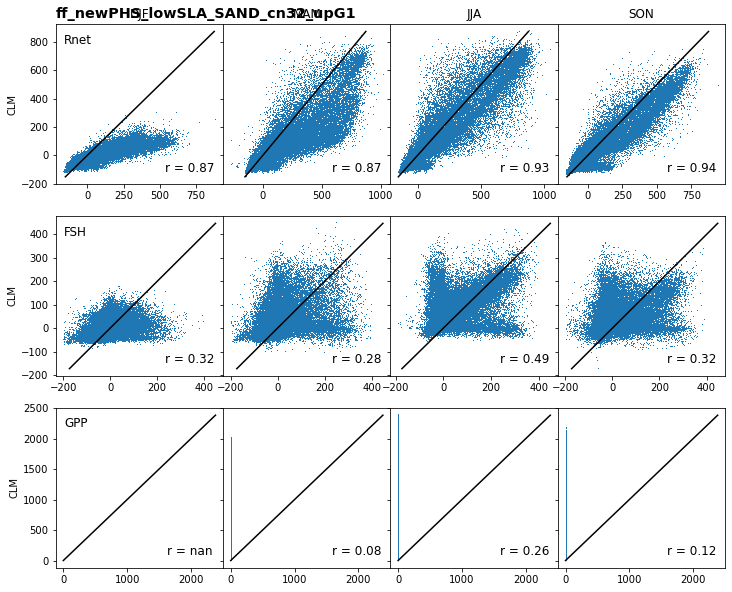

In [97]:
fig, axs = plt.subplots(len(Var), len(Season), sharey='row', #sharey='col',
                        gridspec_kw={'wspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    ymin = ds[Var[v]][:,2].min()
    ymax = ds[Var[v]][:,2].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = ds[Var[v]][:,2].where(ds.season==Season[i]).values
        axs[v,i].plot(x, y,',')
        line = mlines.Line2D([ymin, ymax], [ymin, ymax], color='k')
        axs[v,i].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[v,i].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[v,i].transAxes)

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            #axs[v,i].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
            #    transform=axs[v,i].transAxes)
            if i == 0:
                axs[i, v].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel(longSite)
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel('CLM')
            axs[v,i].text(0.05, 0.90,(Var[v]), fontsize=12, ha='left', va='center', 
                transform=axs[v,i].transAxes)

#plt.savefig(OUTdir+site[0]+'_FluxScatter.pdf');

In [65]:
## Plot diel cycle

In [68]:
#Can't groupby hour & minutes, so combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
ds['HourMin'] = np.round(ds['time.hour'] + ds['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
ds['MonDay'] = np.round(ds['time.month'] + ds['time.day']/100,2)

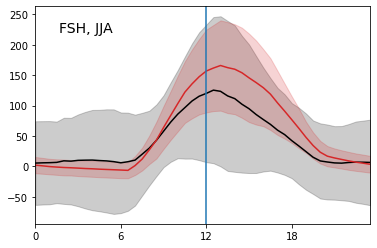

In [80]:
# quick look at one season, variable
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

([<matplotlib.axis.XTick at 0x2b4c431fd190>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

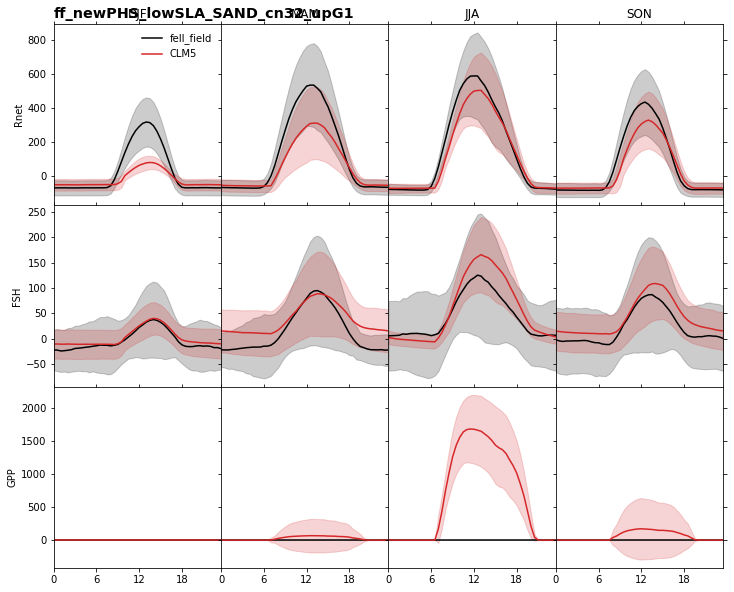

In [98]:
fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        # maybe use resample, not grouby, 
        # eg da.resample(time='1D').mean()
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5'], frameon=False)
                axs[v,i].set_title(site[0], loc='left', 
                                    fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))
#axs[0,0].legend((network+' '+longSite),'CLM5', frameon=False)

#plt.savefig(OUTdir+site[0]+'_FluxDiel.pdf');

In [90]:
ds

<xarray.Dataset>
Dimensions:             (column: 3, gridcell: 1, hist_interval: 2, landunit: 1, levdcmp: 25, levgrnd: 25, levlak: 10, levsoi: 20, lndgrid: 1, time: 210240)
Coordinates:
  * levgrnd             (levgrnd) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * levsoi              (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.95 6.94 8.03
  * levlak              (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.33 44.78
  * levdcmp             (levdcmp) float32 0.01 0.04 0.09 ... 19.48 28.87 42.0
  * time                (time) object 2008-01-01 00:00:00 ... 2019-12-31 23:1...
  * column              (column) <U2 'mm' 'wm' 'dm'
Dimensions without coordinates: gridcell, hist_interval, landunit, lndgrid
Data variables:
    hslp_distance       (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_width          (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_area           (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_elev           (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_slope          (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_aspect         (time, column) float64 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_index          (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_cold           (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    hslp_colu           (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mcdate              (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mcsec               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mdcur               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    mscur               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    nstep               (time, column) int32 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    time_bounds         (time, hist_interval, column) object dask.array<chunksize=(17520, 2, 3), meta=np.ndarray>
    date_written        (time, column) |S16 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    time_written        (time, column) |S16 dask.array<chunksize=(17520, 3), meta=np.ndarray>
    lon                 (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    lat                 (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    area                (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    landfrac            (time, lndgrid, column) float32 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    landmask            (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    pftmask             (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    nbedrock            (time, lndgrid, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_lon          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_lat          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_ixy          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    grid1d_jxy          (time, gridcell, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_lon          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_lat          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_ixy          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=np.ndarray>
    land1d_jxy          (time, landunit, column) float64 dask.array<chunksize=(17520, 1, 3), meta=